In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import pandas as pd

Lọc và bỏ những cột feature được đánh giá là thiếu tính phân loại label 2021 và 2024 ra

In [26]:
# Load the dataset
df = pd.read_csv('dataset.csv')

# Ensure the timestamp column is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Convert the target column to string
target_column = 'What is your intake?'  # Replace with your actual target column name
df[target_column] = df[target_column].astype(str)
df = df[df[target_column].isin(['2021', '2024'])]

# Drop the 'Timestamp' column
df = df.drop('Timestamp', axis=1)

# Reduce the number of features
most_frequent_values = df.groupby(target_column).agg(lambda x: x.mode()[0])
result_df = most_frequent_values.reset_index()
df = df.loc[:, result_df.nunique() > 1]
df[target_column] = df[target_column].astype(str)

get_dummies() có 1 vấn đề là:
- Pool data value là 1, 2, 3, 4; nhưng khi train_test_split thì dataframe được trả ra chưa chắc đã cover hết cái pool data value đó 
- (Tức là nó có thể không có 1 data point nào của, ví dụ, số "1")
- Train val test có thể có số lượng cột (feature) khác nhau => Lỗi

Giải quyết:
- Add thêm 4 row chưa riêng giá trị 1, 2, 3, 4 với label là 2025
- Đảm bảo khi get_dummies() sẽ tạo ra số lượng cột dummies bằng nhau
- Encode xong thì loại những row 2025 ra 

In [27]:
# Split the data into training+validation and test sets (e.g., 80% train+val, 20% test)
train_val, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_column])

# Further split the training+validation set into training and validation sets (e.g., 75% train, 25% val)
train, val = train_test_split(train_val, test_size=0.25, random_state=42, stratify=train_val[target_column])  # 0.25 * 80% = 20% validation

# Dummy rows data
dummi1 = ['2025'] + [1] * 10
dummi2 = ['2025'] + [2] * 10
dummi3 = ['2025'] + [3] * 10
dummi4 = ['2025'] + [4] * 10
dummies = [dummi1, dummi2, dummi3, dummi4]

# Create a dictionary for each dummy row based on df.columns
new_rows = []
for dummy in dummies:
    new_row_dict = dict(zip(val.columns, dummy))  # Map columns to values in the dummy row
    new_rows.append(new_row_dict)

# Convert the list of dictionaries to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows to the original DataFrame
train = pd.concat([train, new_rows_df], ignore_index=True)
val = pd.concat([val, new_rows_df], ignore_index=True)
test = pd.concat([test, new_rows_df], ignore_index=True)

In [28]:
y_train = train[target_column]
y_val = val[target_column]
y_test = test[target_column]

# Assuming `train`, `val`, and `test` are your original datasets and target_column is defined
X_train = train.drop(target_column, axis=1)
X_val = val.drop(target_column, axis=1)
X_test = test.drop(target_column, axis=1)

# Using pd.get_dummies to handle categorical columns
dummy_tr = pd.get_dummies(X_train, drop_first=True)
dummy_v = pd.get_dummies(X_val, drop_first=True)
dummy_t = pd.get_dummies(X_test, drop_first=True)

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit the encoder on the training data (dummy_tr)
encoder.fit(dummy_tr)

# Transform the training, validation, and test data
encoded_tr = encoder.transform(dummy_tr)
encoded_v = encoder.transform(dummy_v)
encoded_t = encoder.transform(dummy_t)

# Get the feature names from the encoder after fitting
encoded_columns = encoder.get_feature_names_out(input_features=dummy_tr.columns)

# Convert the encoded arrays to DataFrames
encoded_tr_df = pd.DataFrame(encoded_tr, columns=encoded_columns)
encoded_v_df = pd.DataFrame(encoded_v, columns=encoded_columns)
encoded_t_df = pd.DataFrame(encoded_t, columns=encoded_columns)

# Add the encoded target column to the DataFrames
encoded_tr_df[target_column] = y_train
encoded_v_df[target_column] = y_val
encoded_t_df[target_column] = y_test

### FIX FROM HERE
df_train = encoded_tr_df[encoded_tr_df[target_column]!='2025']
df_val = encoded_v_df[encoded_v_df[target_column]!='2025']
df_test = encoded_t_df[encoded_t_df[target_column]!='2025']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to the target column
label_encoder.fit(df_train[target_column])

# Separate the target column from features
df_train[target_column] = label_encoder.transform(df_train[target_column])
df_val[target_column] = label_encoder.transform(df_val[target_column])
df_test[target_column] = label_encoder.transform(df_test[target_column])

# Save to CSV files
df_train.to_csv("train.csv", index=False)
df_val.to_csv("val.csv", index=False)
df_test.to_csv("test.csv", index=False)

print(f"Training set shape: {df_train.shape}\nValidation set shape: {df_val.shape}\nTest set shape: {df_test.shape}")

Training set shape: (48, 28)
Validation set shape: (16, 28)
Test set shape: (16, 28)


D:\Temporary Files\ipykernel_18860\4043521185.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target_column] = label_encoder.transform(df_train[target_column])
D:\Temporary Files\ipykernel_18860\4043521185.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[target_column] = label_encoder.transform(df_val[target_column])
D:\Temporary Files\ipykernel_18860\4043521185.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

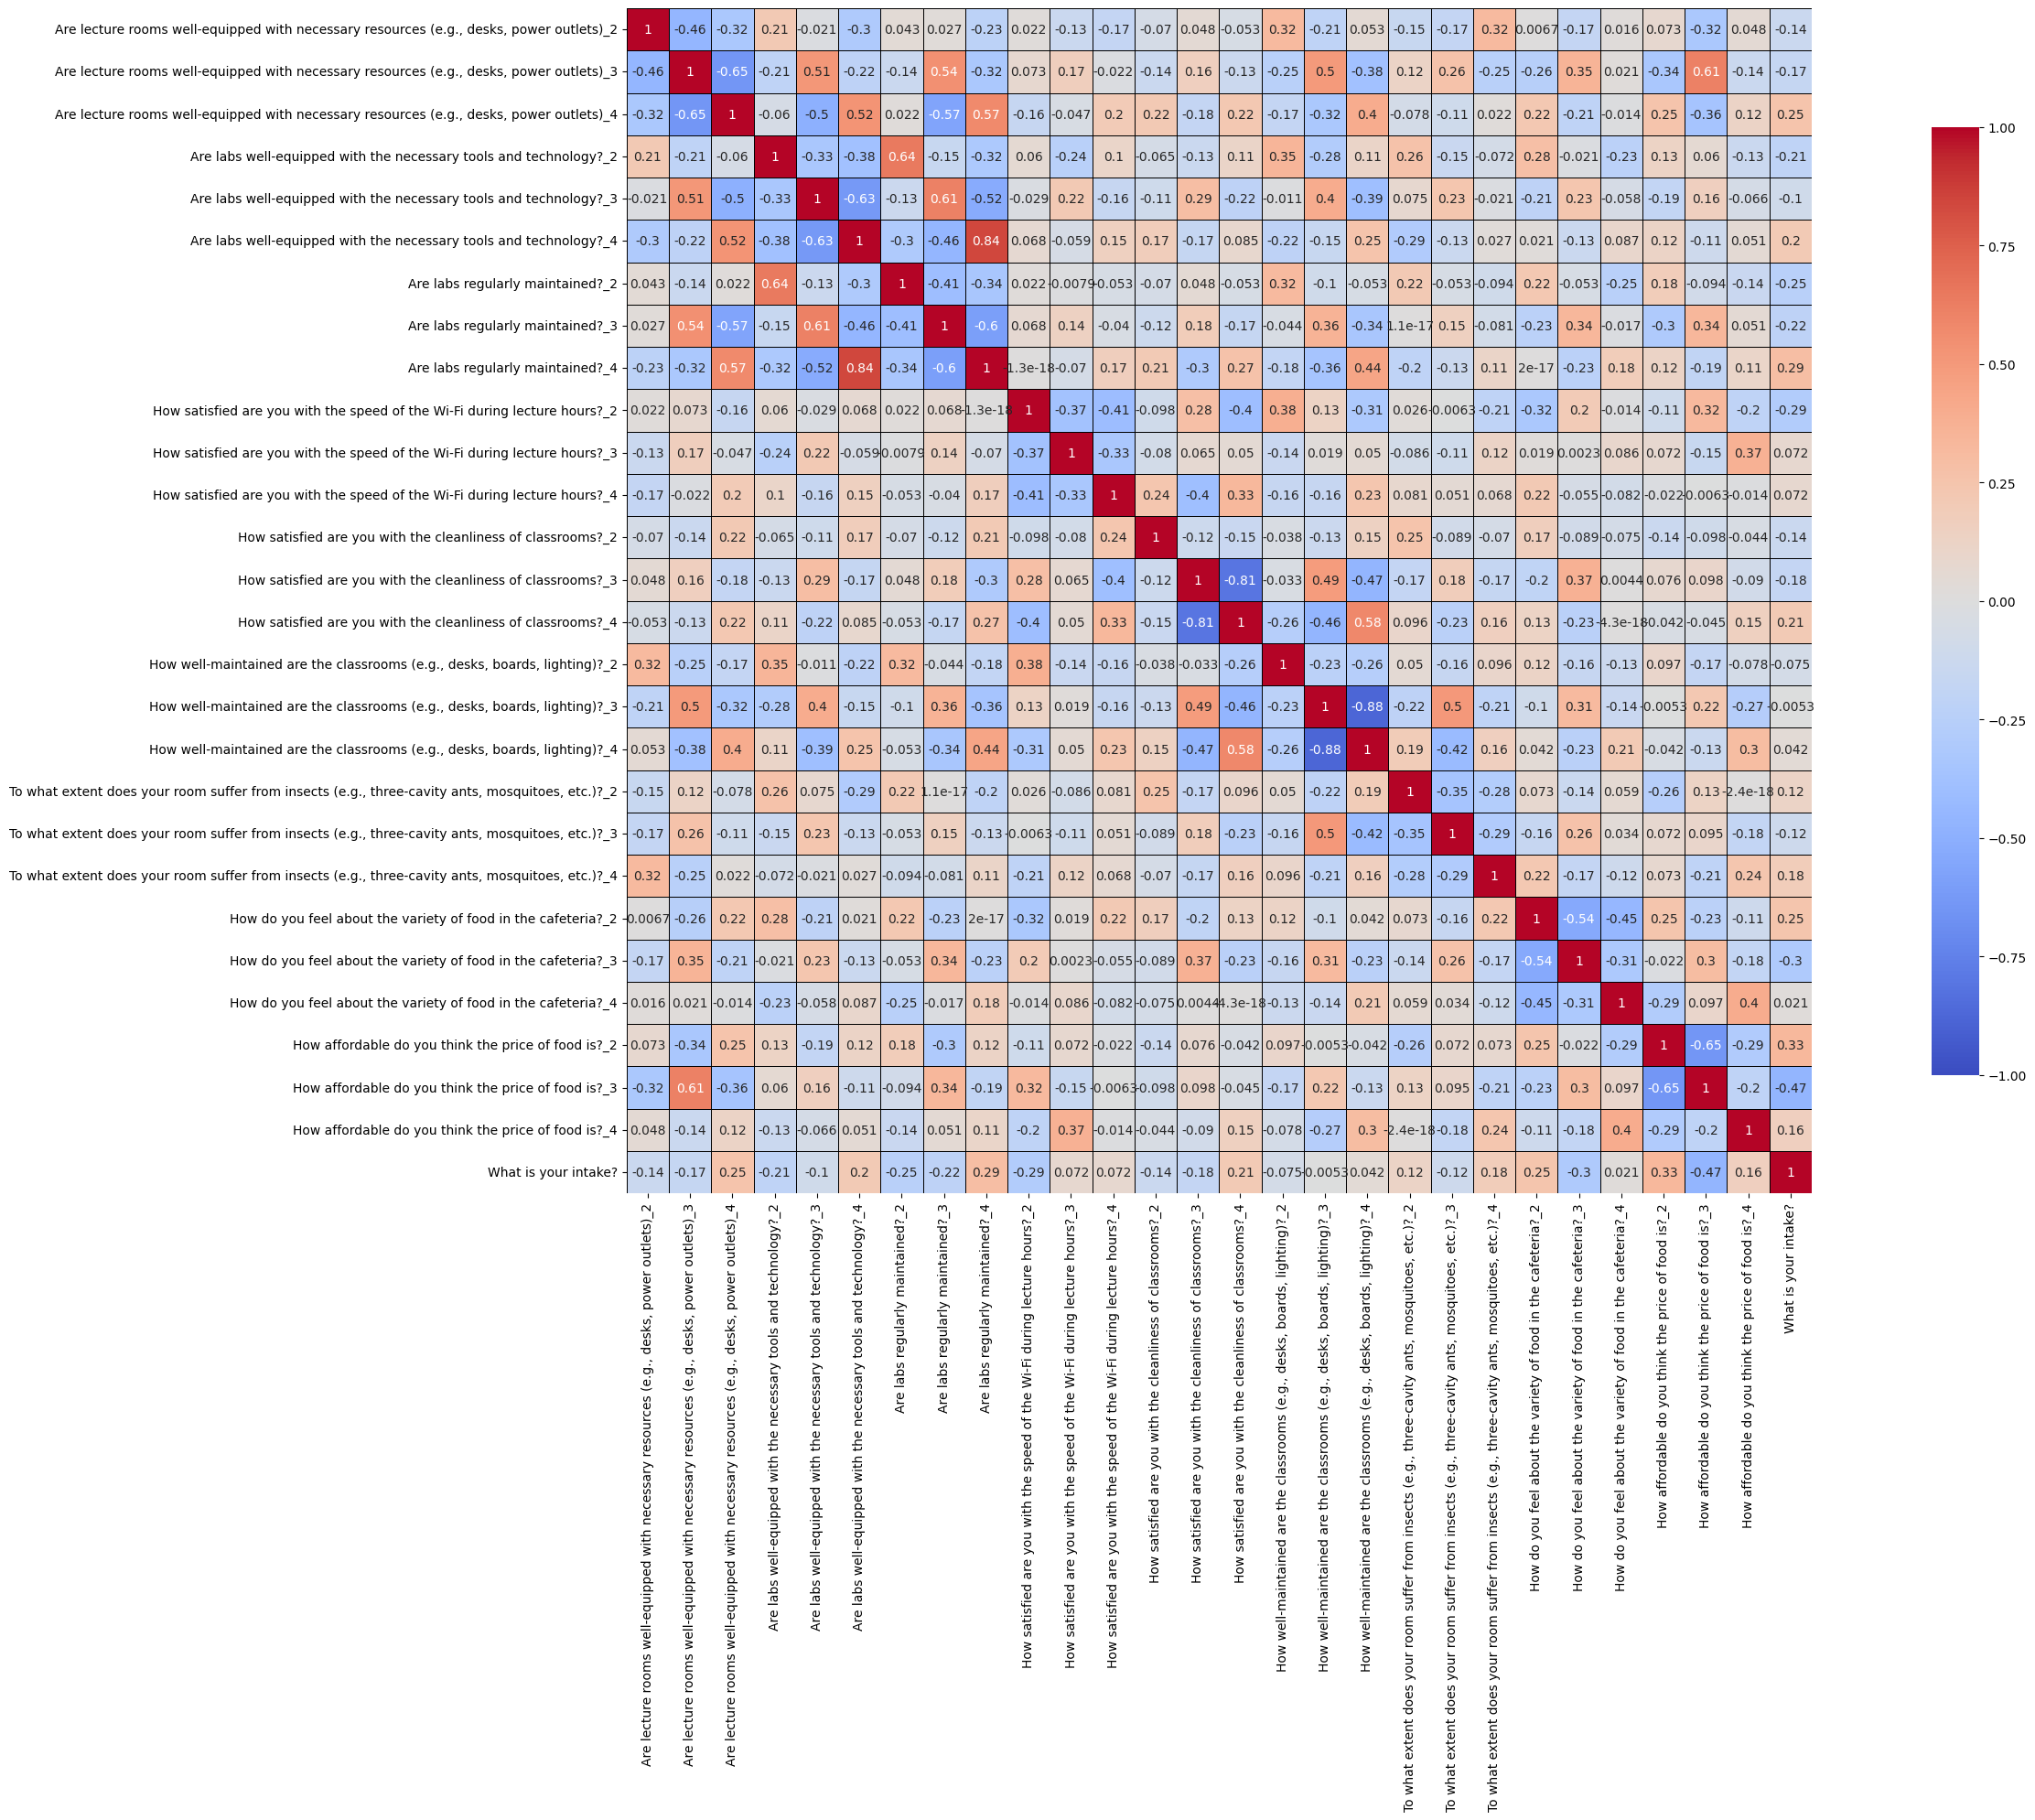

In [29]:
# Assuming `df` is your cleaned DataFrame
correlation_matrix = df_train.corr()

# Set up the plot size
plt.figure(figsize=(30, 20))

# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,         # Annotate cells with correlation coefficients
    cmap='coolwarm',    # Color map for correlation values
    linewidths=0.5,     # Line width between cells
    linecolor='black',  # Color of the lines between cells
    vmin=-1, vmax=1,    # Set the value range for correlations
    square=True,        # Square shape of the heatmap
    cbar_kws={"shrink": 0.8},  # Adjust color bar size
    annot_kws={"size": 10},    # Font size of annotations
)

# Adjust the layout for better spacing and readability
plt.tight_layout()

# Show the plot
plt.show()